<a href="https://colab.research.google.com/github/jayadevgnvrama/Ensemble-Deep-Learning-for-Parkinson-s-Disease-A-Comparative-Study-of-CNN-models-/blob/main/ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torchvision.models as models
from google.colab import drive
import torch.nn as nn
import seaborn as sn
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score,
                             recall_score, f1_score, classification_report)

# 🔹 Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 🔹 Define paths
train_path = '/content/drive/MyDrive/TRAIN_CROP'
test_path = '/content/drive/MyDrive/TEST_CROP'
val_path = '/content/drive/MyDrive/VAL_CROP'

# 🔹 Define transforms with better augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
batch_size = 32
num_epochs = 30

train_loader = torch.utils.data.DataLoader(ImageFolder(train_path, transform=transform), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(ImageFolder(test_path, transform=transform), batch_size=batch_size, shuffle=False)
val_loader = torch.utils.data.DataLoader(ImageFolder(val_path, transform=transform), batch_size=batch_size, shuffle=False)

# 🔹 Load pre-trained ResNet50 model
resnet50 = models.resnet50(pretrained=True)

# 🔹 Unfreeze the last 3 layers to allow fine-tuning
for param in list(resnet50.parameters())[:-10]:
    param.requires_grad = False


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# 🔹 Modify last layer
num_classes = 2
resnet50.fc = nn.Linear(resnet50.fc.in_features, num_classes)

# 🔹 Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50.to(device)

# 🔹 Define loss function and optimizer with weight decay
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.parameters(), lr=0.0001, weight_decay=1e-4)

# 🔹 Learning rate scheduler for better convergence
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


In [ ]:
# 🔹 Training loop with accuracy tracking
accuracy_list = []
loss_list = []

for epoch in range(num_epochs):
    resnet50.train()
    running_loss = 0.0
    total_correct = 0
    total_samples = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet50(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        running_loss += loss.item()

    accuracy = 100 * total_correct / total_samples
    accuracy_list.append(accuracy)
    loss_list.append(running_loss / len(train_loader))

    scheduler.step()  # Update learning rate

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}, Accuracy: {accuracy:.2f}%')


Epoch 1/30, Loss: 0.5477, Accuracy: 68.97%
Epoch 2/30, Loss: 0.3855, Accuracy: 84.48%
Epoch 3/30, Loss: 0.3323, Accuracy: 84.10%
Epoch 4/30, Loss: 0.3223, Accuracy: 85.82%
Epoch 5/30, Loss: 0.3043, Accuracy: 88.89%
Epoch 6/30, Loss: 0.2879, Accuracy: 87.16%
Epoch 7/30, Loss: 0.2849, Accuracy: 88.89%
Epoch 8/30, Loss: 0.2936, Accuracy: 86.21%
Epoch 9/30, Loss: 0.2540, Accuracy: 89.27%
Epoch 10/30, Loss: 0.2469, Accuracy: 88.51%
Epoch 11/30, Loss: 0.2548, Accuracy: 89.08%
Epoch 12/30, Loss: 0.2714, Accuracy: 90.80%
Epoch 13/30, Loss: 0.2645, Accuracy: 89.66%
Epoch 14/30, Loss: 0.2701, Accuracy: 88.89%
Epoch 15/30, Loss: 0.2875, Accuracy: 87.93%
Epoch 16/30, Loss: 0.2567, Accuracy: 90.42%
Epoch 17/30, Loss: 0.2520, Accuracy: 90.04%
Epoch 18/30, Loss: 0.2791, Accuracy: 87.16%
Epoch 19/30, Loss: 0.2323, Accuracy: 92.34%
Epoch 20/30, Loss: 0.2524, Accuracy: 89.08%
Epoch 21/30, Loss: 0.2624, Accuracy: 87.55%
Epoch 22/30, Loss: 0.2426, Accuracy: 91.19%
Epoch 23/30, Loss: 0.2498, Accuracy: 91.1

In [ ]:
# 🔹 Save the trained model weights
model_path = "/content/drive/MyDrive/resnet50_finetuned.pth"
torch.save(resnet50.state_dict(), model_path)
print(f"Model weights saved as '{model_path}'")


Model weights saved as '/content/drive/MyDrive/resnet50_finetuned.pth'


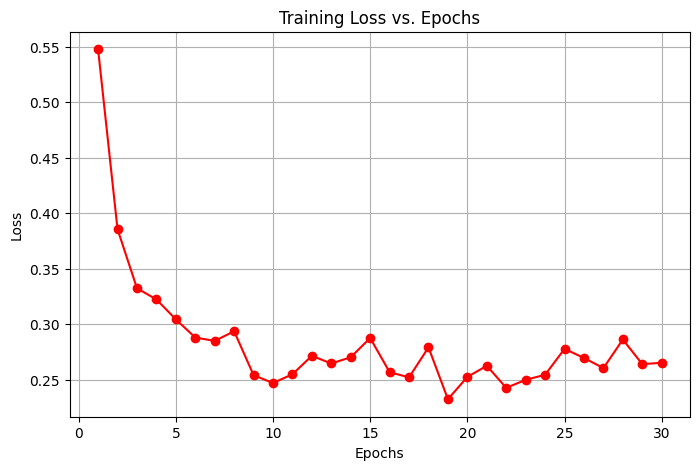

In [ ]:
import matplotlib.pyplot as plt

# 🔹 Plot Loss vs. Epochs
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs+1), loss_list, marker='o', linestyle='-', color='r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epochs')
plt.grid(True)
plt.show()



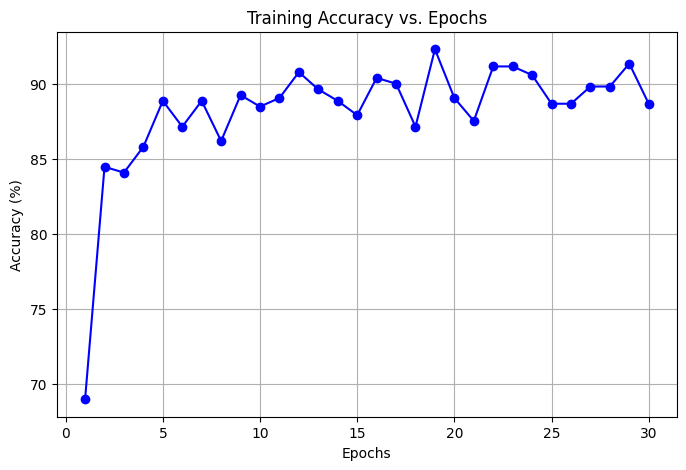

In [ ]:
# 🔹 Plot Accuracy vs. Epochs
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs+1), accuracy_list, marker='o', linestyle='-', color='b')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy vs. Epochs')
plt.grid(True)
plt.show()

In [ ]:
# 🔹 Evaluate on Test Set
resnet50.eval()
correct = 0
total = 0
actual = []
prediction = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet50(images)
        _, predicted = torch.max(outputs.data, 1)

        actual.extend(labels.cpu().tolist())
        prediction.extend(predicted.cpu().tolist())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Test Accuracy: %d %%' % (100 * correct / total))


Test Accuracy: 95 %


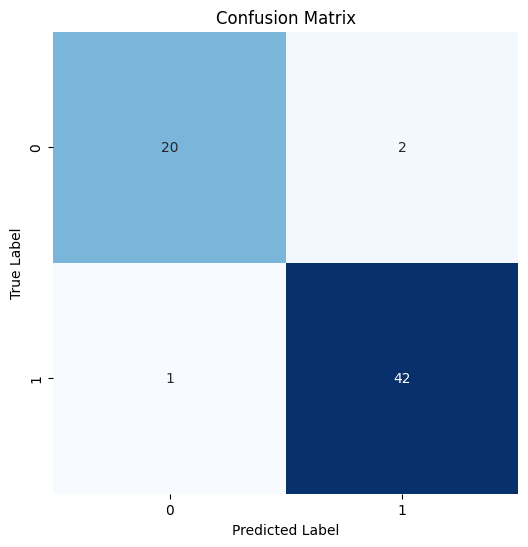

In [ ]:
# 🔹 Compute Confusion Matrix
confusion_mtx = confusion_matrix(actual, prediction)
plt.figure(figsize=(6,6))
sn.heatmap(confusion_mtx, annot=True, fmt='d', cmap="Blues", cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# 🔹 Calculate Additional Statistics
precision = precision_score(actual, prediction)
recall = recall_score(actual, prediction)
f1 = f1_score(actual, prediction)
print("Precision:", precision)
print("Recall (Sensitivity):", recall)
print("F1 Score:", f1)


Precision: 0.9545454545454546
Recall (Sensitivity): 0.9767441860465116
F1 Score: 0.9655172413793104


In [ ]:
# 🔹 Print Classification Report
print("Classification Report:")
print(classification_report(actual, prediction, target_names=["Non-PD", "PD"]))


Classification Report:
              precision    recall  f1-score   support

      Non-PD       0.95      0.91      0.93        22
          PD       0.95      0.98      0.97        43

    accuracy                           0.95        65
   macro avg       0.95      0.94      0.95        65
weighted avg       0.95      0.95      0.95        65



In [ ]:
# 🔹 Load Model for Prediction
model = models.resnet50(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.load_state_dict(torch.load(model_path))
model.to(device)
model.eval()

# 🔹 Define the image transformation for prediction
predict_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 🔹 Function to make predictions
def predict_image(image_path):
    img = Image.open(image_path)

    # Convert grayscale images to RGB (ResNet requires 3 channels)
    if img.mode == 'L':
        img = img.convert('RGB')

    img = predict_transform(img).unsqueeze(0).to(device)  # Add batch dimension & move to GPU

    with torch.no_grad():
        outputs = model(img)
        _, predicted = torch.max(outputs, 1)

    class_names = ['Non-PD', 'PD']
    predicted_class = class_names[predicted.item()]
    print(f'Predicted class: {predicted_class}')
    return predicted_class

# 🔹 Example usage:
image_path = '/content/drive/MyDrive/TEST_CROP/NO/7.jpg'
predicted_class = predict_image(image_path)

<ipython-input-35-a311f3db7183>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Predicted class: Non-PD
